In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import feo_thermodynamics as feot
import earth_model
import layer_setup

In [2]:
# Flayer setup
f_layer_thickness = 200_000 # m
xfe_outer_core = 0.83 # mol frac Fe

# Transport and growth properties
growth_prefactor = 150.0 # (k0) m/s
chemical_diffusivity = 1.0e-9
thermal_conductivity = 100.0
kinematic_viscosity = 1.0e-6

# Nucleation
i0 = 1.0e-10 # (I0) # s^-1m^-3
surf_energy = 1.08e-2 # (gamma) J/m^2
wetting_angle = 180.0 # degrees

# Numerics
number_of_analysis_points = 100
number_of_knots = 5

# Sensible defaults below
hetrogeneous_radius=None
r_icb=1221.5E3
r_cmb=3480.0E3
gruneisen_parameter=1.5
start_time=0.0
max_time=1.0E12
max_rel_error=1.0E-5
max_absolute_error=1.0E-8
verbose=False

k0 = 150.0
dl = 1.0E-9
k = 100.0
mu = 1.0E-6
i0 = 1.0E-10
surf_energy = 1.08E-2
wetting_angle = 180.0
hetrogeneous_radius = None

In [3]:
# Setup the f-layer

# Derived radii
r_flayer_top = r_icb + f_layer_thickness
        
# Discretisation points
nucleation_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
analysis_radii = np.linspace(r_icb, r_flayer_top, number_of_analysis_points)
knott_radii = np.linspace(r_icb, r_flayer_top, number_of_knots)

# Reuse general layer setup code, but we don't need many of the functions
# so we never need to rerun this (fairly expensive) function
_, adiabatic_temperature_function, _, _, _, pressure_function, gravity_function, _ = layer_setup.setup_flayer_functions(
    r_icb, r_cmb, f_layer_thickness, gruneisen_parameter, 10, xfe_outer_core, xfe_outer_core, knott_radii)

/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


In [4]:
import collections

cases_dict = collections.defaultdict(list)

for delta_t_icb in [70.0, 60.0, 50.0, 40.0, 30.0, 20.0, 10.0, 5.0, 0.0, -5.0, -10.0, -20.0, -30.0, -40.0, -50.0, -60.0, -70.0]:
    for delta_x_icb in [0.015, 0.0125, 0.01, 0.0075, 0.005, 0.0025, 0.00125, 0.0, -0.000625, -0.00125, -0.001875, -0.0025]:

        temperature_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, adiabatic_temperature_function(r_icb)+delta_t_icb, 
            adiabatic_temperature_function(r_flayer_top))
        composition_function = layer_setup.fit_quad_func_boundaries(
            r_icb, r_flayer_top, xfe_outer_core+delta_x_icb, xfe_outer_core)
        
        # Check the temperature is below the liquidus temperature at the ICB
        t_icb = temperature_function(r_icb)
        x_icb = composition_function(r_icb)
        tl = feot.find_liquidus(composition_function(r_icb), pressure_function(r_icb))
        dt_liq = tl - t_icb
        
        # Check temperature increases downwards
        t_flayer_top = temperature_function(r_flayer_top)
        dt_cond = t_icb - t_flayer_top
        
        # Check the layer is stratified
        Nbv, N2 = layer_setup.estimate_brunt_vaisala_frequency(
            r_flayer_top, r_icb, temperature_function, adiabatic_temperature_function,
            composition_function, gravity_function, pressure_function)
        
        cases_dict["dt"].append(delta_t_icb)
        cases_dict["dx"].append(delta_x_icb)
        cases_dict["N2"].append(N2)
        cases_dict["dT_liq"].append(dt_liq)
        cases_dict["dT_cond"].append(dt_cond)
        print(f"Dt = {delta_t_icb}, delta_x = {delta_x_icb}, BV freq = {Nbv}, dT_liq = {dt_liq}, dT_cond = {dt_cond}")
        if (N2 >= 0.0) and (dt_liq > 0.0) and (dt_cond > 0.0):
            solutions, particle_densities, growth_rate, solid_vf, \
            particle_radii, partial_particle_densities, \
            crit_nuc_radii, nucleation_rates, t_points_out, xl_points_out, total_latent_heat, total_o_rate =flayer.evaluate_flayer(
            temperature_function, composition_function, pressure_function, gravity_function, 0.0, 1.0E20,
                    k0, dl, k, mu, i0, surf_energy, wetting_angle, hetrogeneous_radius,
                    nucleation_radii, analysis_radii, r_icb, 
                    r_flayer_top, verbose=False, silent=True)

            max_particle_radius = particle_radii.max()
            
            print(f"Heat from crystalisation = {total_latent_heat/1.0E12} TW, oxygen = {total_o_rate/1.0E9} Tg/s")
            print(f"maximum particle radius = {max_particle_radius} m")
            cases_dict["total_latent_heat"].append(total_latent_heat)
            cases_dict["total_o_rate"].append(total_o_rate)
            cases_dict["max_particle_radius"].append(max_particle_radius)
            
            
        else:
            cases_dict["total_latent_heat"].append(None)
            cases_dict["total_o_rate"].append(None)
            cases_dict["max_particle_radius"].append(None)


Dt = 70.0, delta_x = 0.015, BV freq = 0.00027353141674197294, dT_liq = 33.84857891950742, dT_cond = 138.1575349600398


/Users/andreww/Code/slurry/falling.py:186: RuntimeWarning: invalid value encountered in double_scalars
  delta_u_prefac_low_fr = (fr/1.0e-2)**(-0.5)
/Users/andreww/Code/slurry/falling.py:187: RuntimeWarning: invalid value encountered in double_scalars
  delta_u_low_fr = delta_u_prefac_low_fr * (fr/re)**(0.5) * 2.0 * radius # above eq I3.11
/Users/andreww/Code/slurry/falling.py:188: RuntimeWarning: invalid value encountered in double_scalars
  delta_c_prefac_low_fr = (1.0E-2)**(1/6) * (1.0E-2*sc)**(1/3) * fr**(-1/6)
/Users/andreww/Code/slurry/falling.py:189: RuntimeWarning: invalid value encountered in double_scalars
  delta_c_low_fr = delta_c_prefac_low_fr * fr**(1/6) / (re**(1/6) * pe_c**(1/3)) * 2.0 * radius # eq I3.12
/Users/andreww/Code/slurry/flayer.py:484: RuntimeWarning: invalid value encountered in divide
  mean_particle_velocities[i] = np.mean((partial_densities * partial_velocities) /


Heat from crystalisation = 2.5759868675907254 TW, oxygen = 0.0001462048665178489 Tg/s
maximum particle radius = 0.01777756682287667 m


/Users/andreww/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


Dt = 70.0, delta_x = 0.0125, BV freq = 0.0002451982894038744, dT_liq = 20.00303018708746, dT_cond = 138.1575349600398
Heat from crystalisation = 0.12030432585697351 TW, oxygen = 6.927245796644738e-06 Tg/s
maximum particle radius = 0.009112410018037078 m
Dt = 70.0, delta_x = 0.01, BV freq = 0.00021318913901610765, dT_liq = 6.1943792242364, dT_cond = 138.1575349600398
Heat from crystalisation = 1.8629583611604458e-05 TW, oxygen = 1.0887306867775953e-09 Tg/s
maximum particle radius = 0.0023576177206311453 m
Dt = 70.0, delta_x = 0.0075, BV freq = 0.00017550380128125286, dT_liq = -7.577702847594992, dT_cond = 138.1575349600398
Dt = 70.0, delta_x = 0.005, BV freq = 0.0001271929715058285, dT_liq = -21.313541396281835, dT_cond = 138.1575349600398
Dt = 70.0, delta_x = 0.0025, BV freq = 3.973584798103175e-05, dT_liq = -35.01345833657797, dT_cond = 138.1575349600398
Dt = 70.0, delta_x = 0.00125, BV freq = 7.557437454914596e-05j, dT_liq = -41.85004587609728, dT_cond = 138.1575349600398
Dt = 70.0, 

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.76677e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 11.310519003261836 TW, oxygen = 0.0006426085916085519 Tg/s
maximum particle radius = 0.02417519147474278 m
Dt = 60.0, delta_x = 0.0125, BV freq = 0.00024896824988957623, dT_liq = 30.003030187085642, dT_cond = 128.15753496004254
Heat from crystalisation = 1.2828302117573576 TW, oxygen = 7.389938467983869e-05 Tg/s
maximum particle radius = 0.015139804903353996 m
Dt = 60.0, delta_x = 0.01, BV freq = 0.00021751172159045098, dT_liq = 16.19437922423458, dT_cond = 128.15753496004254
Heat from crystalisation = 0.03290792538576255 TW, oxygen = 1.9233711090646593e-06 Tg/s
maximum particle radius = 0.007139777153284498 m
Dt = 60.0, delta_x = 0.0075, BV freq = 0.00018072653271042745, dT_liq = 2.422297152403189, dT_cond = 128.15753496004254
Heat from crystalisation = 4.4171184630688714e-15 TW, oxygen = 2.6199328524437903e-19 Tg/s
maximum particle radius = 0.0007562814845837341 m
Dt = 60.0, delta_x = 0.005, BV freq = 0.0001343030390188941, dT_liq = -11.313541396283654, dT_

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.44311e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 0.588125481852424 TW, oxygen = 3.4383427183832266e-05 Tg/s
maximum particle radius = 0.012745615377971666 m
Dt = 50.0, delta_x = 0.0075, BV freq = 0.00018580230473784782, dT_liq = 12.422297152405008, dT_cond = 118.15753496004072
Heat from crystalisation = 0.0057726204217173815 TW, oxygen = 3.424054724064022e-07 Tg/s
maximum particle radius = 0.005278765626899564 m
Dt = 50.0, delta_x = 0.005, BV freq = 0.00014105489027874127, dT_liq = -1.3135413962818347, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = 0.0025, BV freq = 7.276601366409063e-05, dT_liq = -15.013458336577969, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = 0.00125, BV freq = 4.4685184919226175e-05j, dT_liq = -21.850045876097283, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = 0.0, BV freq = 9.634493143099712e-05j, dT_liq = -28.67777220179687, dT_cond = 118.15753496004072
Dt = 50.0, delta_x = -0.000625, BV freq = 0.00011367875489999353j, dT_liq = -32.08832469717527, dT_cond = 118.157534960040

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.77409e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 15.546953099154786 TW, oxygen = 0.000910026979691505 Tg/s
maximum particle radius = 0.025942719475043133 m
Dt = 30.0, delta_x = 0.0075, BV freq = 0.0001955584170657454, dT_liq = 32.4222971524041, dT_cond = 98.15753496004072
Heat from crystalisation = 2.1304875790078626 TW, oxygen = 0.00012642935814337835 Tg/s
maximum particle radius = 0.017128196266979347 m
Dt = 30.0, delta_x = 0.005, BV freq = 0.0001536704204934026, dT_liq = 18.686458603717256, dT_cond = 98.15753496004072
Heat from crystalisation = 0.08345798640859997 TW, oxygen = 5.023264017735823e-06 Tg/s
maximum particle radius = 0.008537380855122602 m
Dt = 30.0, delta_x = 0.0025, BV freq = 9.492383263427083e-05, dT_liq = 4.9865416634211215, dT_cond = 98.15753496004072
Heat from crystalisation = 1.0871025483763629e-06 TW, oxygen = 6.63724411477459e-11 Tg/s
maximum particle radius = 0.0018297821977328662 m
Dt = 30.0, delta_x = 0.00125, BV freq = 4.14444300464249e-05, dT_liq = -1.8500458760981928, dT_cond =

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.44962e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 0.02103467057069487 TW, oxygen = 1.2842871758156128e-06 Tg/s
maximum particle radius = 0.006602837947417443 m
Dt = 20.0, delta_x = 0.00125, BV freq = 5.978901559098765e-05, dT_liq = 8.149954123902717, dT_cond = 88.15753496004072
Heat from crystalisation = 0.0002605177267187982 TW, oxygen = 1.6019002623034108e-08 Tg/s
maximum particle radius = 0.003190231016133809 m
Dt = 20.0, delta_x = 0.0, BV freq = 6.093195439438484e-05j, dT_liq = 1.32222779820313, dT_cond = 88.15753496004072
Dt = 20.0, delta_x = -0.000625, BV freq = 8.575628411543079e-05j, dT_liq = -2.088324697175267, dT_cond = 88.15753496004072
Dt = 20.0, delta_x = -0.00125, BV freq = 0.00010485256625542424j, dT_liq = -5.496676610407121, dT_cond = 88.15753496004072
Dt = 20.0, delta_x = -0.001875, BV freq = 0.00012096472780462026j, dT_liq = -8.902832820234835, dT_cond = 88.15753496004072
Dt = 20.0, delta_x = -0.0025, BV freq = 0.00013516418010258596j, dT_liq = -12.306798195992087, dT_cond = 88.157534960040

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.88318e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 124.7397163404542 TW, oxygen = 0.007207993402254341 Tg/s
maximum particle radius = 0.04256807881428777 m
Dt = 10.0, delta_x = 0.01, BV freq = 0.00023794720149109143, dT_liq = 66.1943792242364, dT_cond = 78.1575349600389
Heat from crystalisation = 69.24214065748741 TW, oxygen = 0.004057053948748152 Tg/s
maximum particle radius = 0.03652014838143583 m
Dt = 10.0, delta_x = 0.0075, BV freq = 0.00020484964834101453, dT_liq = 52.42229715240501, dT_cond = 78.1575349600389
Heat from crystalisation = 28.55968191172783 TW, oxygen = 0.0016964544688536183 Tg/s
maximum particle radius = 0.029549852548839857 m
Dt = 10.0, delta_x = 0.005, BV freq = 0.00016532513490930028, dT_liq = 38.686458603718165, dT_cond = 78.1575349600389
Heat from crystalisation = 6.167656862257002 TW, oxygen = 0.00037139309005376477 Tg/s
maximum particle radius = 0.02126965736364122 m
Dt = 10.0, delta_x = 0.0025, BV freq = 0.00011280895988368795, dT_liq = 24.98654166342203, dT_cond = 78.1575349600389

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.53714e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 0.3055723565889314 TW, oxygen = 1.87899682891413e-05 Tg/s
maximum particle radius = 0.01128016772524713 m
Dt = 5.0, delta_x = 0.0, BV freq = 3.046549461713673e-05j, dT_liq = 16.32222779820313, dT_cond = 73.1575349600389
Dt = 5.0, delta_x = -0.000625, BV freq = 6.760211076671299e-05j, dT_liq = 12.911675302824733, dT_cond = 73.1575349600389
Dt = 5.0, delta_x = -0.00125, BV freq = 9.061140795376267e-05j, dT_liq = 9.503323389592879, dT_cond = 73.1575349600389
Dt = 5.0, delta_x = -0.001875, BV freq = 0.00010885445846511343j, dT_liq = 6.097167179765165, dT_cond = 73.1575349600389
Dt = 5.0, delta_x = -0.0025, BV freq = 0.00012444534607469466j, dT_liq = 2.693201804007913, dT_cond = 73.1575349600389
Dt = 0.0, delta_x = 0.015, BV freq = 0.0002964244700964269, dT_liq = 103.84857891950742, dT_cond = 68.15753496003981
Heat from crystalisation = 251.49065320754625 TW, oxygen = 0.01433159997717978 Tg/s
maximum particle radius = 0.051966584169840964 m
Dt = 0.0, delta_x = 0.0

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.89596e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 57.09805802977531 TW, oxygen = 0.0033928366270373116 Tg/s
maximum particle radius = 0.034785452019522475 m
Dt = 0.0, delta_x = 0.005, BV freq = 0.00017085427579806918, dT_liq = 48.686458603718165, dT_cond = 68.15753496003981
Heat from crystalisation = 20.87287493162696 TW, oxygen = 0.0012573089794924823 Tg/s
maximum particle radius = 0.02750304290102298 m
Dt = 0.0, delta_x = 0.0025, BV freq = 0.00012076177984576779, dT_liq = 34.98654166342203, dT_cond = 68.15753496003981
Heat from crystalisation = 3.499230223106349 TW, oxygen = 0.00021368692199769622 Tg/s
maximum particle radius = 0.018966707265480394 m
Dt = 0.0, delta_x = 0.00125, BV freq = 8.537366275933612e-05, dT_liq = 28.149954123902717, dT_cond = 68.15753496003981
Heat from crystalisation = 0.9634816074546106 TW, oxygen = 5.924684547579687e-05 Tg/s
maximum particle radius = 0.014445411750838653 m
Dt = 0.0, delta_x = 0.0, BV freq = -0.0, dT_liq = 21.32222779820313, dT_cond = 68.15753496003981
Heat from c

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.81492e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 14.438909249994635 TW, oxygen = 0.0008818871220604969 Tg/s
maximum particle radius = 0.025527932265547205 m
Dt = -10.0, delta_x = 0.00125, BV freq = 9.56321734973889e-05, dT_liq = 38.14995412390181, dT_cond = 58.15753496004072
Heat from crystalisation = 5.87522775532813 TW, oxygen = 0.0003613076107718114 Tg/s
maximum particle radius = 0.02119515057300212 m
Dt = -10.0, delta_x = 0.0, BV freq = 4.3084033236691085e-05, dT_liq = 31.32222779820222, dT_cond = 58.15753496004072
Heat from crystalisation = 1.8406803070381352 TW, oxygen = 0.00011398096486061011 Tg/s
maximum particle radius = 0.016602481687759116 m
Dt = -10.0, delta_x = -0.000625, BV freq = 4.2262594542230595e-05j, dT_liq = 27.911675302823824, dT_cond = 58.15753496004072
Dt = -10.0, delta_x = -0.00125, BV freq = 7.366797292916127e-05j, dT_liq = 24.50332338959197, dT_cond = 58.15753496004072
Dt = -10.0, delta_x = -0.001875, BV freq = 9.52171058493144e-05j, dT_liq = 21.097167179764256, dT_cond = 58.157534

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.75119e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Radius 7299.458526255467 m capped to 2 m in falling
Radius 7299.458526255467 m capped to 2 m in falling


/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.81017e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 9.326698858225573 TW, oxygen = 0.0005775397991493135 Tg/s
maximum particle radius = 0.023218948348492374 m
Dt = -20.0, delta_x = -0.000625, BV freq = 8.34989612029525e-06, dT_liq = 37.91167530282473, dT_cond = 48.15753496004072
Heat from crystalisation = 5.749186438262367 TW, oxygen = 0.00035723400885159394 Tg/s
maximum particle radius = 0.020910256729274185 m
Dt = -20.0, delta_x = -0.00125, BV freq = 5.97614441475507e-05j, dT_liq = 34.50332338959288, dT_cond = 48.15753496004072
Dt = -20.0, delta_x = -0.001875, BV freq = 8.491798766810915e-05j, dT_liq = 31.097167179765165, dT_cond = 48.15753496004072
Dt = -20.0, delta_x = -0.0025, BV freq = 0.00010415941462418422j, dT_liq = 27.693201804007913, dT_cond = 48.15753496004072
Dt = -30.0, delta_x = 0.015, BV freq = 0.00030570950318394306, dT_liq = 133.84857891950742, dT_cond = 38.15753496003981
Heat from crystalisation = 464.36765328769957 TW, oxygen = 0.026473613788061772 Tg/s
maximum particle radius = 0.062519794

/Users/andreww/Code/slurry/falling.py:65: UserWarning: Calculated Re 7.88538e+06 too high for drag / velocity parameterisation. Treat results with care
  warnings.warn(


Heat from crystalisation = 45.28241825075665 TW, oxygen = 0.00278513216975555 Tg/s
maximum particle radius = 0.03291165258236302 m
Dt = -30.0, delta_x = 0.0, BV freq = 7.462215864094025e-05, dT_liq = 51.32222779820313, dT_cond = 38.15753496003981
Heat from crystalisation = 27.332667365850696 TW, oxygen = 0.001692528456278653 Tg/s
maximum particle radius = 0.029250241441773895 m
Dt = -30.0, delta_x = -0.000625, BV freq = 4.3880406107883805e-05, dT_liq = 47.91167530282473, dT_cond = 38.15753496003981
Heat from crystalisation = 20.11260889754605 TW, oxygen = 0.0012496743706735703 Tg/s
maximum particle radius = 0.027349919070283106 m
Dt = -30.0, delta_x = -0.00125, BV freq = 4.142425082951649e-05j, dT_liq = 44.50332338959288, dT_cond = 38.15753496003981
Dt = -30.0, delta_x = -0.001875, BV freq = 7.318408558792582e-05j, dT_liq = 41.097167179765165, dT_cond = 38.15753496003981
Dt = -30.0, delta_x = -0.0025, BV freq = 9.483847632047361e-05j, dT_liq = 37.69320180400791, dT_cond = 38.1575349600

In [5]:
import pandas as pd

In [6]:
results_df = pd.DataFrame(cases_dict)
results_df.to_csv('results2_df.csv', index=False)
results_df

,dt,dx,N2,dT_liq,dT_cond,total_latent_heat,total_o_rate,max_particle_radius
0,70.0,0.015000,7.481944e-08,33.848579,138.157535,2.575987e+12,146204.866518,0.017778
1,70.0,0.012500,6.012220e-08,20.003030,138.157535,1.203043e+11,6927.245797,0.009112
2,70.0,0.010000,4.544961e-08,6.194379,138.157535,1.862958e+07,1.088731,0.002358
3,70.0,0.007500,3.080158e-08,-7.577703,138.157535,NaN,NaN,NaN
4,70.0,0.005000,1.617805e-08,-21.313541,138.157535,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
199,-70.0,0.000000,1.299199e-08,91.322228,-1.842465,NaN,NaN,NaN
200,-70.0,-0.000625,9.347783e-09,87.911675,-1.842465,NaN,NaN,NaN
201,-70.0,-0.001250,5.705094e-09,84.503323,-1.842465,NaN,NaN,NaN
202,-70.0,-0.001875,2.063923e-09,81.097167,-1.842465,NaN,NaN,NaN


In [7]:
snow_df = results_df[~results_df["total_latent_heat"].isna()]
unstable_df = results_df[results_df["N2"] < 0.0]
wrong_dtdr_df = results_df[results_df["dT_cond"] < 0.0]
melting_df = results_df[results_df["dT_liq"] < 0.0]

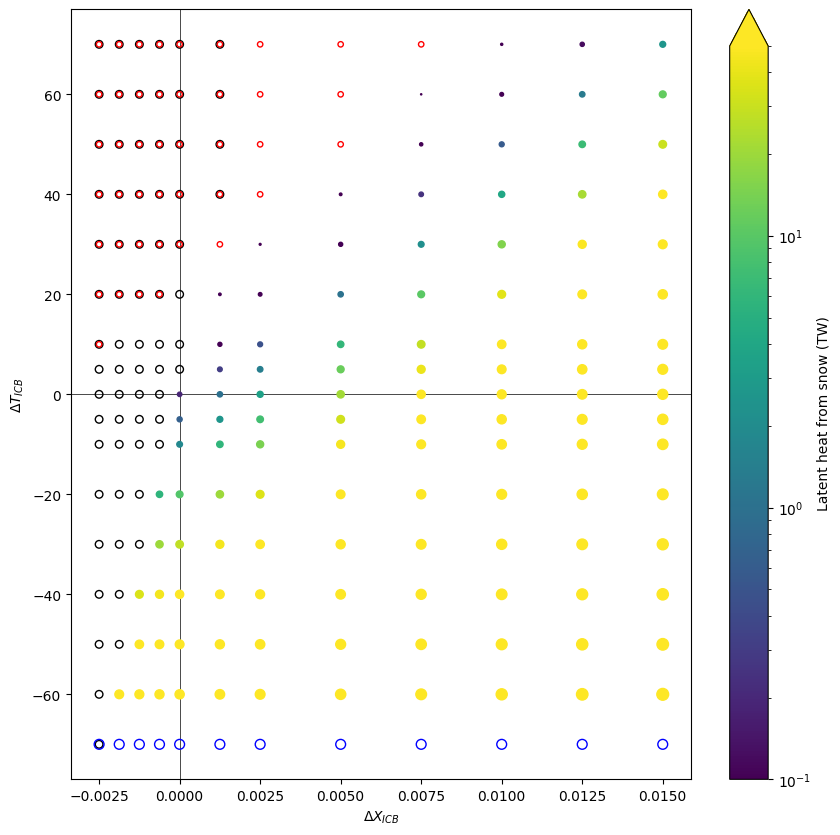

In [8]:
import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(10,10))
ax.axhline(c='k', lw=0.5, zorder=0)
ax.axvline(c='k', lw=0.5, zorder=0)
ax.scatter(unstable_df["dx"], unstable_df["dt"], s=30, facecolors='none', edgecolors='k')
ax.scatter(wrong_dtdr_df["dx"], wrong_dtdr_df["dt"], s=50, facecolors='none', edgecolors='b')
ax.scatter(melting_df["dx"], melting_df["dt"], s=15, facecolors='none', edgecolors='r')
c = ax.scatter(snow_df["dx"], snow_df["dt"], c=np.array(snow_df["total_latent_heat"])/1.0E12,
              norm=colors.LogNorm(vmin=0.1, vmax=50), cmap='viridis',
              s=snow_df["max_particle_radius"]*1000)
ax.set_ylabel("$\Delta T_{ICB}$")
ax.set_xlabel("$\Delta X_{ICB}$")

#ax.set_ylim(-0.006, 0.006)
fig.colorbar(c, label='Latent heat from snow (TW)', extend='max')
plt.show()


In [9]:
results_df

,dt,dx,N2,dT_liq,dT_cond,total_latent_heat,total_o_rate,max_particle_radius
0,70.0,0.015000,7.481944e-08,33.848579,138.157535,2.575987e+12,146204.866518,0.017778
1,70.0,0.012500,6.012220e-08,20.003030,138.157535,1.203043e+11,6927.245797,0.009112
2,70.0,0.010000,4.544961e-08,6.194379,138.157535,1.862958e+07,1.088731,0.002358
3,70.0,0.007500,3.080158e-08,-7.577703,138.157535,NaN,NaN,NaN
4,70.0,0.005000,1.617805e-08,-21.313541,138.157535,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
199,-70.0,0.000000,1.299199e-08,91.322228,-1.842465,NaN,NaN,NaN
200,-70.0,-0.000625,9.347783e-09,87.911675,-1.842465,NaN,NaN,NaN
201,-70.0,-0.001250,5.705094e-09,84.503323,-1.842465,NaN,NaN,NaN
202,-70.0,-0.001875,2.063923e-09,81.097167,-1.842465,NaN,NaN,NaN


In [10]:
prem = earth_model.Prem()
m_oc = prem.mass(3480.0, r_inner=1221.5)
print(f"Mass of outer core from PREM = {m_oc} kg")
((snow_df["total_o_rate"]*60.0*60.0*24.0*365.0*1.0E9)/m_oc)*100.0

Mass of outer core from PREM = 1.8411154476791537e+24 kg


0       0.250431
1       0.011866
2       0.000002
12      1.100708
13      0.126580
         ...    
186    18.045979
187    14.579836
188    12.944257
189    11.384527
190     9.903803
Name: total_o_rate, Length: 116, dtype: float64

In [11]:
results_df[results_df["dx"] == 0.005][results_df["dt"] == 50.0]

/var/folders/j_/przs7cfj1b7czhv250v8t_440000gn/T/ipykernel_9750/1527972663.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results_df[results_df["dx"] == 0.005][results_df["dt"] == 50.0]


,dt,dx,N2,dT_liq,dT_cond,total_latent_heat,total_o_rate,max_particle_radius
28,50.0,0.005,1.989648e-08,-1.313541,118.157535,NaN,NaN,NaN


In [12]:
-0.0 < 0.0

False